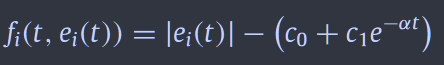

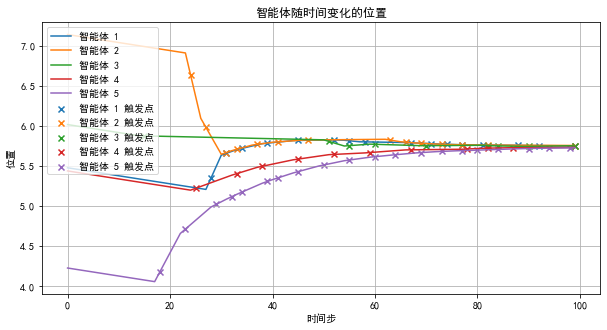

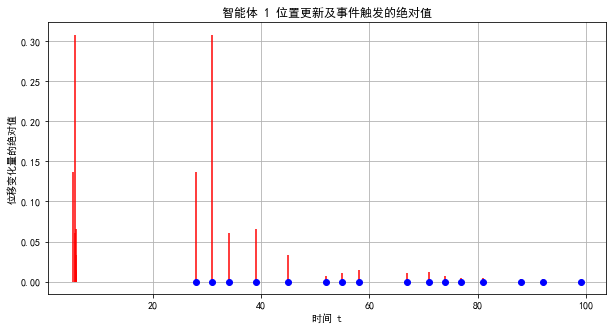

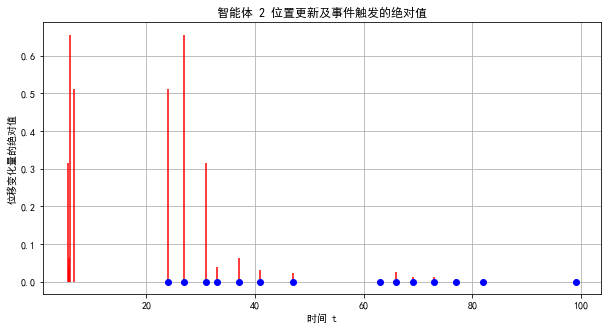

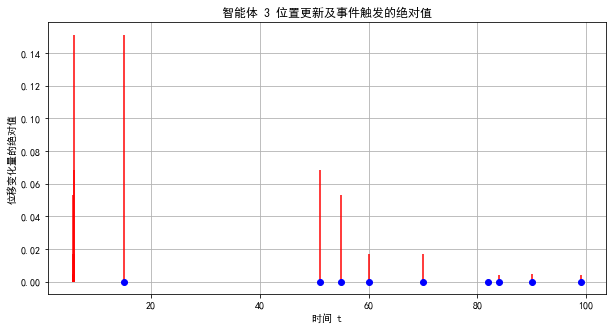

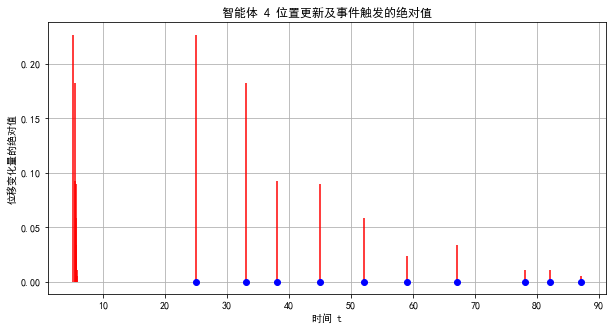

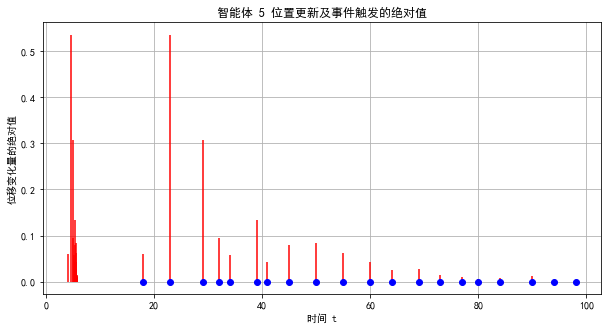

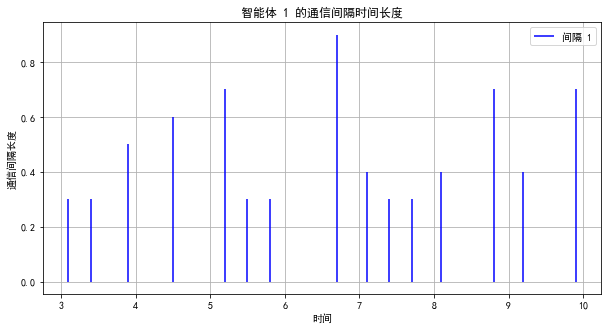

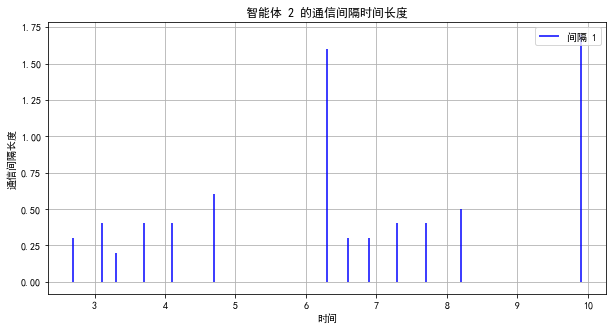

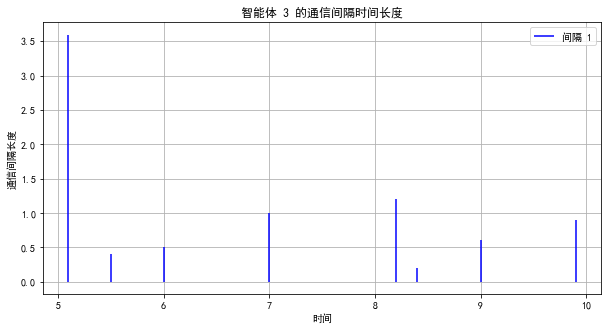

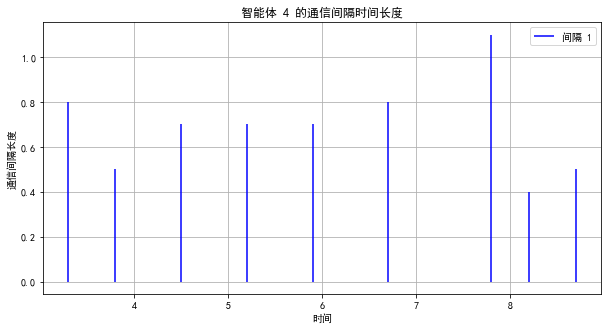

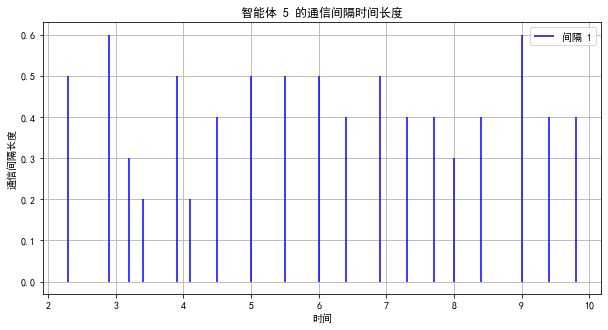

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, initial_position, index):
        self.position = initial_position
        self.index = index
        self.neighbors = []
        self.last_broadcast_position = self.position  #存储了该智能体最近一次广播的位置
        self.trigger_points = []
        self.trigger_points2 = []  # 用于记录事件触发时的位置
        self.delta_positions = []
        self.communication_times = []  # 记录每次通信的时间
        self.z = 0.1
        
    def add_neighbor(self, neighbor):
        if neighbor not in self.neighbors:
            self.neighbors.append(neighbor)
            neighbor.neighbors.append(self)

    def is_neighbor(self, agent):
        return agent in self.neighbors
    
    def get_position(self):
        return self.position
    
        
    def update_position(self, t, dt):
        self.sigma = np.random.uniform(0, 1)
        x_i = self.position
        e_i = self.last_broadcast_position - self.position
        phi_i = sum(self.is_neighbor(neighbor) * (self.last_broadcast_position - neighbor.last_broadcast_position) ** 2 for neighbor in self.neighbors)
        x_update = -self.position + self.sigma / 4 * phi_i - e_i ** 2
        x_i += x_update
        z_bar_squared = sum(self.is_neighbor(neighbor) * (self.position - neighbor.get_position()) for neighbor in self.neighbors)
        trigger_condition = len(self.neighbors) * e_i ** 2 - self.sigma / 4 * phi_i - x_i
        
        # 如果事件触发函数大于等于0，则更新位置并广播新位置
        if trigger_condition >= 0:
            self.position -= z_bar_squared * dt
            #记录触发的相关信息
            self.delta_positions.append(self.last_broadcast_position - self.position)
            self.trigger_points2.append(t * dt)
            self.trigger_points.append((t, self.position))
            self.last_broadcast_position = self.position
            self.last_trigger_time = t
            self.communication_times.append(t * dt)
            self.z = z_bar_squared
        else:
            self.position -= self.z * dt
            
            

# 初始化参数和智能体
num_agents = 5
num_iterations = 100
dt = 0.1
np.random.seed(0)
agents = [Agent(np.random.rand() * 10, i) for i in range(num_agents)]

# 定义邻居关系
agents[0].add_neighbor(agents[1])
agents[0].add_neighbor(agents[2])
agents[1].add_neighbor(agents[2])
agents[2].add_neighbor(agents[3])
agents[3].add_neighbor(agents[4])

L = np.array([[ 2, -1, -1,  0,  0],
              [-1,  2, -1,  0,  0],
              [-1, -1,  3, -1,  0],
              [ 0,  0, -1,  2, -1],
              [ 0,  0,  0, -1,  1]])

# 计算拉普拉斯矩阵的特征值
eigenvalues = np.linalg.eigvalsh(L)
# 谱范数是所有特征值的绝对值中的最大值
spectral_norm = np.max(np.abs(eigenvalues))
# 第二小的特征值，也被称为网络的代数连通性
second_smallest_eigenvalue = np.partition(eigenvalues, 1)[1]



# 运行模拟
positions = np.zeros((num_iterations, num_agents))
for t in range(num_iterations):
    current_average_position = np.mean([agent.position for agent in agents])
    for agent in agents:
        agent.update_position(t, dt)
        positions[t, agent.index] = agent.position

# 绘制结果图
plt.figure(figsize=(10, 5))
for i, agent in enumerate(agents):
    plt.plot(positions[:, i], label=f'智能体 {i+1}')
    # 绘制事件触发点
    if agent.trigger_points:
        trigger_times, trigger_positions = zip(*agent.trigger_points)
        plt.scatter(trigger_times, trigger_positions, marker='x', label=f'智能体 {i + 1} 触发点')
plt.xlabel('时间步')
plt.ylabel('位置')
plt.title('智能体随时间变化的位置')
plt.legend()
plt.grid(True)


for index, agent in enumerate(agents):
    plt.figure(figsize=(10, 5))
    for trigger_time, delta_position in zip(agent.trigger_points, agent.delta_positions):  
        if delta_position != 0:
            absolute_delta = abs(delta_position)
            plt.vlines(trigger_time, 0, absolute_delta, colors='r')
            plt.plot(trigger_time[0], 0, 'bo')  
    plt.xlabel('时间 t')
    plt.ylabel('位移变化量的绝对值')
    plt.title(f'智能体 {index + 1} 位置更新及事件触发的绝对值')
    plt.grid(True)


for index, agent in enumerate(agents):
    if len(agent.communication_times) > 1:
        # 计算相邻两次通信的时间间隔
        intervals = np.diff(agent.communication_times)
        plt.figure(figsize=(10, 5))  # 为每个智能体创建一个新的图形
        for i, time in enumerate(agent.communication_times[1:]):
            # 在每次通信时间点上绘制一条垂直线，长度代表时间间隔
            plt.vlines(time, 0, intervals[i], label=f'间隔 {i+1}' if i == 0 else "", color='b')  # 仅在第一条线添加图例标签
        plt.xlabel('时间')
        plt.ylabel('通信间隔长度')
        plt.title(f'智能体 {index + 1} 的通信间隔时间长度')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 解决中文显示问题
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号 '-' 显示为方块的问题

plt.show()